In [1]:
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7' 'langchain_chroma==0.1.4'  'langchain_community==0.3.12' 'faiss-cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 43.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [2]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("key")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [22]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")


In [23]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [24]:
from urllib.request import urlretrieve

file_url="https://cdn.redcross.ca/prodmedia/crc/documents/2018-First-Aid-Pocket-Guide_1.pdf"
local_filename = "downloaded_file_urllib.pdf"

try:
    urlretrieve(file_url, local_filename)
    print(f"File '{local_filename}' downloaded successfully using urllib.")
except Exception as e:
    print(f"Error downloading file with urllib: {e}")

File 'downloaded_file_urllib.pdf' downloaded successfully using urllib.


In [25]:
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool


# Load docs
docs = PyPDFLoader("/kaggle/working/downloaded_file_urllib.pdf").load()

# Split text
splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=256)
splits = splitter.split_documents(docs)

# Build FAISS store
faiss_store = FAISS.from_documents(splits, embedding=embeddings)

# Turn into a retriever tool
help_features = create_retriever_tool(
    faiss_store.as_retriever(search_kwargs={"k": 1}),
    name="first_aid_help",
    description="This clinic provides first aid help to its customers."
)

In [26]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver

chatbot_prompt = """
    You are a chatbot. You can give great answers about first aid help to people who are in danger.
    You can just advice them based on your tool and dont use your own memory. You can greet with people.
    """



tools = [help_features]


memory=MemorySaver()


First_Aid_Agent=create_react_agent(
                                model=llm, 
                                tools=tools, 
                                prompt=SystemMessage(chatbot_prompt), 
                                debug=False,
                                checkpointer=memory 
)

In [27]:
config = {"configurable": {"thread_id": "test-thread"}}
First_Aid_Agent.invoke(
    {
        "messages": [
            ("user", "Hi, I'm polly!im choking?")
        ]
    },
    config,
)["messages"][-1].content

"Hi polly! I'm sorry to hear that you're choking.  I am a chatbot and can't provide direct medical assistance, but I can offer some guidance.\n\nIf you are choking and can still speak or cough forcefully, it's best to encourage you to keep coughing to try and dislodge the object.  If you cannot cough or breathe, you will need immediate help.\n\nSomeone nearby should call emergency services immediately. If someone is available to help, they should perform the Heimlich maneuver.  I cannot guide you through that process as I am not qualified to do so, but a trained professional will know how to help."

In [9]:
import pandas as pd

# Sample clinic appointment data
data = [
    {"appointment_id": "yy-1", "patient_name": "Alice Johnson", "doctor": "Dr. Smith", "date": "2025-09-05", "time": "10:00", "status": "confirmed"},
    {"appointment_id": "yy-2", "patient_name": "Bob Williams", "doctor": "Dr. Lee", "date": "2025-09-06", "time": "14:30", "status": "canceled"},
    {"appointment_id": "yy-3", "patient_name": "Charlie Brown", "doctor": "Dr. Patel", "date": "2025-09-07", "time": "09:15", "status": "changed"},
    {"appointment_id": "yy-4", "patient_name": "Diana Ross", "doctor": "Dr. Smith", "date": "2025-09-05", "time": "11:45", "status": "confirmed"},
    {"appointment_id": "yy-5", "patient_name": "Edward King", "doctor": "Dr. Lee", "date": "2025-09-08", "time": "16:00", "status": "confirmed"},
    {"appointment_id": "yy-6", "patient_name": "Fiona Adams", "doctor": "Dr. Patel", "date": "2025-09-09", "time": "13:00", "status": "canceled"},
    {"appointment_id": "yy-7", "patient_name": "George Harris", "doctor": "Dr. Smith", "date": "2025-09-10", "time": "15:30", "status": "changed"},
    {"appointment_id": "yy-8", "patient_name": "Helen Clark", "doctor": "Dr. Lee", "date": "2025-09-11", "time": "09:00", "status": "confirmed"},
    {"appointment_id": "yy-9", "patient_name": "Ian Wright", "doctor": "Dr. Patel", "date": "2025-09-12", "time": "10:30", "status": "canceled"},
    {"appointment_id": "yy-10", "patient_name": "Jane Foster", "doctor": "Dr. Smith", "date": "2025-09-13", "time": "14:00", "status": "confirmed"},
]

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
file_path = "/clinic_appointments.csv"
df.to_csv(file_path, index=False)



In [10]:
import pandas as pd

appointment_df = pd.read_csv(file_path)
print(appointment_df)

  appointment_id   patient_name     doctor        date   time     status
0           yy-1  Alice Johnson  Dr. Smith  2025-09-05  10:00  confirmed
1           yy-2   Bob Williams    Dr. Lee  2025-09-06  14:30   canceled
2           yy-3  Charlie Brown  Dr. Patel  2025-09-07  09:15    changed
3           yy-4     Diana Ross  Dr. Smith  2025-09-05  11:45  confirmed
4           yy-5    Edward King    Dr. Lee  2025-09-08  16:00  confirmed
5           yy-6    Fiona Adams  Dr. Patel  2025-09-09  13:00   canceled
6           yy-7  George Harris  Dr. Smith  2025-09-10  15:30    changed
7           yy-8    Helen Clark    Dr. Lee  2025-09-11  09:00  confirmed
8           yy-9     Ian Wright  Dr. Patel  2025-09-12  10:30   canceled
9          yy-10    Jane Foster  Dr. Smith  2025-09-13  14:00  confirmed


In [11]:
from langchain_core.tools import tool

@tool
def get_appointment_datail(appointment_id:str) -> str :
    """
    This function returns details about patients appointments. If patients provide their 
    appoitnments id, this function will give them their appointments time date their doctor
    name. If there isn't any match, it returns 'no match'.
    """
    #Filter Dataframe for appointment_id
    match_appointment_df = appointment_df[
                        appointment_df["appointment_id"] == appointment_id ]
    
    #Check if a record was found, if not return -1
    if len(match_appointment_df) == 0 :
        return "no match"
    else:
        return match_appointment_df.iloc[0].to_dict()
# get_appointment_datail(8)

In [12]:
@tool
def update_appointment_time(appointment_id: str, new_time: int) -> str:
    """
    Update the time of an appointment.
    Return 'Done' if updated, 'no match' if appointment not found.
    """
    if appointment_id not in appointment_df["appointment_id"].values:
        return "no match"
    
    appointment_df.loc[
        appointment_df["appointment_id"] == appointment_id, "time"
    ] = new_time
    return "Done"
# update_appointment_time("yy-8","10:00")
# appointment_df

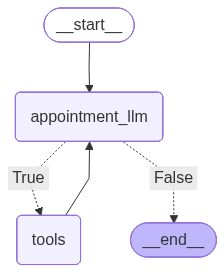

In [13]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, END,START
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage,AIMessage
from IPython.display import Image
from langgraph.graph.message import add_messages
from typing import Literal

class AppointmentAgentState(TypedDict):
    messages: Annotated[list, add_messages]


class AppointmentAgent:

    
    def __init__(self, model, tools, system_prompt):
        
        self.system_prompt=system_prompt
        self.model=llm.bind_tools(tools)
        

        
        graph_builder=StateGraph(AppointmentAgentState)
        
        graph_builder.add_node("appointment_llm",self.invoke_llm)
        graph_builder.add_node("tools",self.invoke_tools)
        graph_builder.add_conditional_edges(
            "appointment_llm",
            self.maybe_route_to_tools,
            {True: "tools", False: END }
        )
        graph_builder.add_edge("tools","appointment_llm")
        graph_builder.add_edge(START, "appointment_llm")


        
        
        self.memory=InMemorySaver()
        
        self.agent_graph = graph_builder.compile(checkpointer=self.memory)

        
        self.tools = { tool.name : tool for tool in tools }
        
        

         
    def invoke_llm(self, state:AppointmentAgentState):
        
    
        msgs = state.get("messages", [])
        msgs.insert(0, SystemMessage(content=self.system_prompt))
        new_output = self.model.invoke(msgs)

        return { "messages":[new_output] }
    
    
    
    def maybe_route_to_tools(self, state:AppointmentAgentState):
        msgs = state.get("messages", [])
        msg = msgs[-1]
        
        if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0 :
            return True
        else:
            return False
    
    def invoke_tools(self, state:AppointmentAgentState):
        
        msgs = state.get("messages", [])
        tool_calls = msgs[-1].tool_calls
        results=[]

        for tool in tool_calls:
            result=self.tools[tool["name"]].invoke(tool["args"])
            results.append(ToolMessage(content=result,
                                       tool_call_id=tool['id'], 
                                       name=tool['name']))
            
            return { "messages" : results }



system_prompt = """
    You are a clinic chatbot, you can give detaild about appointments and change them.
    Just use your tools and handle small talk.you can save detal of your conversation and use them
    """

Appointment_Agent = AppointmentAgent(llm, 
                           [get_appointment_datail, update_appointment_time], 
                           system_prompt
                           )
                           

Image(Appointment_Agent.agent_graph.get_graph().draw_mermaid_png())

In [14]:


sample_patient_inputs = [
    "How are you doing?",
    "Please show me the details of the appointment 'yy-8' ",
    "Can you change my appointment time to 20:00 without any confirmation question ",
    "can you show me my appointment detail again",
    "Bye"
]

#Create a new thread to be unique and use memory specifically for this conversation.
config = {"configurable": {"thread_id": "patient"}}

for input_ in sample_patient_inputs:
    print( "user:",input_)
    
    user_message = {"messages":[HumanMessage(input_)]}
    
    ai_response = Appointment_Agent.agent_graph.invoke(user_message,config=config)
    msgs = ai_response.get("messages", [])
    
    print("agent", msgs[-1].content)


user: How are you doing?
agent I'm doing great, thank you for asking! How can I help you today?
user: Please show me the details of the appointment 'yy-8' 
agent OK.  Here are the details for appointment yy-8:

* **Appointment ID:** yy-8
* **Patient Name:** Helen Clark
* **Doctor:** Dr. Lee
* **Date:** September 11, 2025
* **Time:** 9:00 AM
* **Status:** Confirmed


Is there anything else I can help you with?
user: Can you change my appointment time to 20:00 without any confirmation question 
agent OK. I've updated the time for appointment yy-8 to 8 PM.  Is there anything else?
user: can you show me my appointment detail again
agent Here are the updated details for appointment yy-8:

* **Appointment ID:** yy-8
* **Patient Name:** Helen Clark
* **Doctor:** Dr. Lee
* **Date:** September 11, 2025
* **Time:** 8:00 PM
* **Status:** Confirmed
user: Bye
agent Goodbye! Have a great day.


In [28]:

from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage



def First_Aid_Agent_node(state, config):
    result = First_Aid_Agent.invoke(state, config)
    return {"messages": [AIMessage(result["messages"][-1].content)]}



def Appointment_Agent_node(state, config):
    result = Appointment_Agent.agent_graph.invoke(state, config)
    return {"messages": [AIMessage(result["messages"][-1].content)]}
    
class clinic_Router_state(TypedDict):
    messages: Annotated[list, add_messages]

class Router:

    def __init__(self, llm, system_prompt):
        
        self.system_prompt=system_prompt
        
        self.model=llm
        
        router_graph=StateGraph(clinic_Router_state)
        router_graph.add_node("Router",self.call_llm)
        router_graph.add_node("First_Aid_Agent_node",First_Aid_Agent_node)
        router_graph.add_node("Appointment_Agent_node",Appointment_Agent_node)
        
        router_graph.add_conditional_edges(
            "Router",
            self.find_route,
            {"First_Aid": "First_Aid_Agent_node", 
             "Appointment" : "Appointment_Agent_node",
             "END": END }
        )

        #One way routing, not coming back to router
        router_graph.add_edge("First_Aid_Agent_node",END)
        router_graph.add_edge("Appointment_Agent_node",END)
        
        
        router_graph.add_edge(START, "Router")
        self.router_graph = router_graph.compile()
    

    def call_llm(self, state:clinic_Router_state)-> clinic_Router_state:


        messages=state["messages"]
        messages = [SystemMessage(content=self.system_prompt)] + messages

        
        result = self.model.invoke(messages)
        return { "messages":[result] }

    def find_route(self, state:clinic_Router_state):
        last_message = state["messages"][-1]  
        agent=last_message.content
           
        return agent

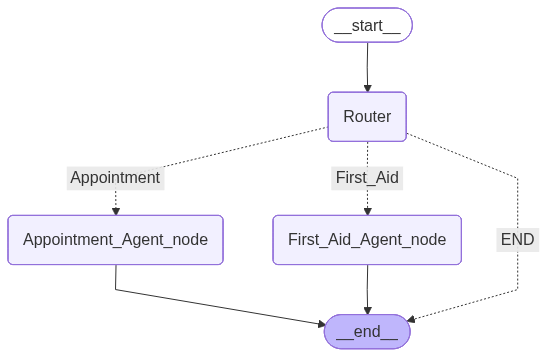

In [29]:
#Create the chatbot
from IPython.display import Image

#Setup the system problem
system_prompt = """ 
You are a Router and have acess to agents. first you should find out which agents to use.choose between these 3 options:

First_Aid: If the query is a first aid help .
Appointment: If the query is about apointments its detail and changes
END: Default, when its neither First_Aid or Appointment.

The is just one of these words nothing else :  First_Aid, Appointment, END.
"""


router_agent = Router(llm, system_prompt)

Image(router_agent.router_graph.get_graph().draw_mermaid_png())

In [30]:
config = {"configurable": {"thread_id": "patient"}}
input_="i want detail of my appoinment yy-5"
chatbot_response = router_agent.router_graph.invoke({"messages":[HumanMessage(input_)]}, config)

In [64]:

msgs = chatbot_response.get("messages", [])

print("agent", msgs[-1].content)

agent OK. Your appointment details are as follows:

* **Appointment ID:** yy-5
* **Patient Name:** Edward King
* **Doctor:** Dr. Lee
* **Date:** 2025-09-08
* **Time:** 16:00
* **Status:** Confirmed

Is there anything else I can help you with today?
